# Feature selection and its combination with data over-sampling for multi-class imbalanced datasets

<b>Background Research</b>
<body>
    <ul>Performa Metode Seleksi Fitur pada Dataset Multi-Kelas yang Tidak Seimbang</ul>
    <ul>Optimalisasi Kombinasi antara Seleksi Fitur dan Teknik Pengambilan Sampel Data Berlebih (Over-sampling)</ul>
</body>

<b>Datasets: </b> Gas Sensor Array Drift (UCIML Repository)

<b>Multiclass Labels</b>

```
[Ammonia, Acetaldehyde, Acetone, Ethylene, Ethanol, Toluene]
```


---
- Tsai, C.-F., Chen, K.-C. dan Lin, W.-C., 2024. Feature selection and its combination with data over-sampling for multi-class imbalanced datasets. Applied Soft Computing, 153, pp.1-15. DOI:10.1016/j.asoc.2024.111267
- Vergara,Alexander., 2012. Gas Sensor Array Drift Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5RP6W.

## Load Datasets

In [2]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import os
import time
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
# load dataset
path = f"{os.getcwd()}/datasets/"
all_files = glob.glob(os.path.join(path, "*.dat"))
print(all_files)

['/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch8.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch9.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch4.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch5.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch7.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch6.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch2.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch3.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch1.dat', '/Users/pabrik/working/academic/MASTER/PROJECTS/DataScience/GasArray/datasets/batch10.dat']


In [4]:
# Remove batch 7 as there is an experimental error which caused mismatches in concentration levels. 
    # Refer to (https://www.sciencedirect.com/science/article/pii/S2352340915000050) for more info.

# Read each .dat file and concat all
df_from_each_file = (pd.read_csv(f, sep="\s+",index_col=0, header=None) for f in all_files)
df = pd.concat(df_from_each_file, sort=True)

# Seperate feature and value in each cell eg. 1:15596.16 --> 15596.16 
for col in df.columns.values:
    df[col] = df[col].apply(lambda x: float(str(x).split(':')[1]))

# Make Index(Gas type) a column and reset index to original
df = df.rename_axis('Gas').reset_index()

# Sort by Gas and reindex
df.sort_values(by=['Gas'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [5]:
df

,Gas,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1,42572.5776,6.879777,8.015992,9.693781,10.395843,-6.536626,-8.133166,-9.791521,38322.2808,...,-2.527925,-3.265795,7569.4060,5.047939,2.276808,4.044630,4.462146,-1.542438,-2.157614,-2.467686
1,1,55613.2022,8.010889,11.923483,14.852244,15.832542,-9.475042,-12.010242,-14.690817,49066.2905,...,-3.431357,-3.867759,9439.2753,6.171099,3.041165,5.965897,6.484808,-2.020718,-2.976985,-3.414326
2,1,69842.5259,10.051341,15.340578,19.488398,20.497949,-12.591432,-15.902563,-18.574193,60936.1982,...,-4.286628,-4.829090,11239.6850,7.103307,3.624351,7.399946,8.102601,-2.474856,-3.703714,-4.142096
3,1,78903.8154,12.166384,18.824513,24.350939,25.197136,-14.415973,-18.179882,-21.087264,67652.2422,...,-5.176868,-5.792909,12906.3768,7.865789,4.189577,8.636098,9.585280,-2.866935,-4.348264,-5.098510
4,1,102471.0781,15.558152,24.911318,33.082695,34.439873,-19.629322,-31.771161,-28.489385,86513.1313,...,-6.725848,-7.586845,16157.8314,9.359470,5.296148,11.308695,12.523619,-3.912921,-6.101352,-6.257501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13905,6,45011.4219,9.636010,13.220786,20.964984,26.488360,-8.718806,-12.385817,-30.353280,46801.9082,...,-4.928583,-10.371440,14795.7119,4.134654,4.388144,8.040886,10.056534,-2.773902,-4.373377,-10.130382
13906,6,23811.0547,3.518754,7.711738,14.056361,19.113196,-4.555740,-6.969796,-21.281989,24257.9101,...,-1.356599,-4.135600,3906.1152,1.824906,1.393279,3.116271,5.714046,-0.815939,-1.260279,-4.056153
13907,6,38627.7217,9.003664,11.091043,18.140143,22.865487,-7.322582,-10.566081,-26.209645,40699.8897,...,-4.114295,-8.741281,12234.7490,3.780909,3.709037,7.248170,9.816069,-2.296547,-3.535484,-7.894552
13908,6,29545.5908,8.390102,8.689338,14.704963,17.619347,-5.369652,-7.882489,-19.172225,31877.3711,...,-2.705141,-7.513827,9215.5232,3.279317,3.045571,6.396584,8.672781,-1.541343,-2.389240,-5.397296


## Exploratory data analysis
---

1. Information on data types
2. Missing values
3. Correlation
4. etc..

### 1. Inistial observation

In [6]:
print("Number of gases :", df.Gas.nunique())

Number of gases : 6


In [7]:
df.head()

,Gas,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1,42572.5776,6.879777,8.015992,9.693781,10.395843,-6.536626,-8.133166,-9.791521,38322.2808,...,-2.527925,-3.265795,7569.4060,5.047939,2.276808,4.044630,4.462146,-1.542438,-2.157614,-2.467686
1,1,55613.2022,8.010889,11.923483,14.852244,15.832542,-9.475042,-12.010242,-14.690817,49066.2905,...,-3.431357,-3.867759,9439.2753,6.171099,3.041165,5.965897,6.484808,-2.020718,-2.976985,-3.414326
2,1,69842.5259,10.051341,15.340578,19.488398,20.497949,-12.591432,-15.902563,-18.574193,60936.1982,...,-4.286628,-4.829090,11239.6850,7.103307,3.624351,7.399946,8.102601,-2.474856,-3.703714,-4.142096
3,1,78903.8154,12.166384,18.824513,24.350939,25.197136,-14.415973,-18.179882,-21.087264,67652.2422,...,-5.176868,-5.792909,12906.3768,7.865789,4.189577,8.636098,9.585280,-2.866935,-4.348264,-5.098510
4,1,102471.0781,15.558152,24.911318,33.082695,34.439873,-19.629322,-31.771161,-28.489385,86513.1313,...,-6.725848,-7.586845,16157.8314,9.359470,5.296148,11.308695,12.523619,-3.912921,-6.101352,-6.257501


In [8]:
df.describe()

,Gas,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
count,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,...,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000,13910.000000
mean,3.387994,50435.066174,6.638156,12.936688,18.743953,26.890695,-9.158655,-14.402383,-59.927598,57340.104585,...,-9.601927,-19.136500,19688.565373,6.072066,7.138634,14.929364,19.090980,-4.901016,-8.167792,-16.089791
std,1.728602,69844.785952,13.486391,17.610061,24.899450,38.107685,12.729206,21.304606,131.017675,64045.265134,...,9.220031,26.516679,14281.652395,4.642192,5.248573,12.437311,14.391810,4.195360,7.637701,20.958479
min,1.000000,-16757.598600,0.088287,0.000100,0.000100,0.000100,-131.332873,-227.627758,-1664.735576,-16119.460900,...,-76.069200,-482.278033,-8297.548800,0.712112,0.003238,0.011488,0.118849,-30.205911,-58.844076,-410.152297
25%,2.000000,6694.725950,2.284843,1.633350,2.386836,4.967988,-11.587169,-17.292559,-48.492764,13287.301875,...,-13.212575,-22.363498,8837.838750,3.007381,3.059178,5.407551,8.039227,-6.789599,-11.162406,-18.938690
50%,3.000000,19364.439350,3.871227,4.977123,7.250892,11.680725,-3.338700,-4.956917,-14.040088,37764.263200,...,-7.338850,-13.527887,16313.967300,4.973783,5.809107,11.325214,14.560676,-3.881763,-6.305962,-11.747499
75%,5.000000,63104.837125,8.400619,17.189166,26.411109,34.843226,-1.126897,-1.670327,-5.212213,70300.782575,...,-3.260080,-7.358031,27009.592425,7.389566,10.222169,21.207572,26.547437,-1.804032,-2.874532,-6.429690
max,6.000000,670687.347700,1339.879283,167.079751,226.619457,993.605306,-0.006941,22.201589,115.273147,502202.812500,...,9.270956,11.516418,96706.792700,45.574835,32.203601,297.225880,195.242555,-0.003817,6.851792,8.357968


In [9]:
df.shape

(13910, 129)

### 2. Exploring the numbers
---
Gases in the dataset by number:

- Ethanol
- Ethylene
- Ammonia
- Acetaldehyde
- Acetone
- Toluene

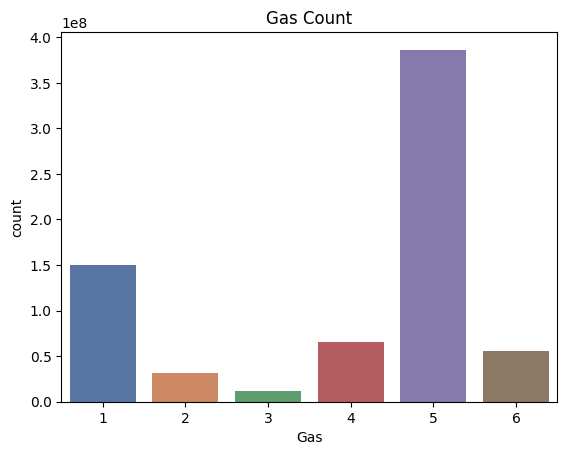

In [10]:
# Now, we'll create a count plot which automatically counts the occurrences of each category.
sns.countplot(x='Gas', data=df, palette='deep')

# You can customize the colors by replacing 'deep' with a list of color codes.

plt.title('Gas Count')
plt.xlabel('Gas')
plt.ylabel('count')
plt.show()

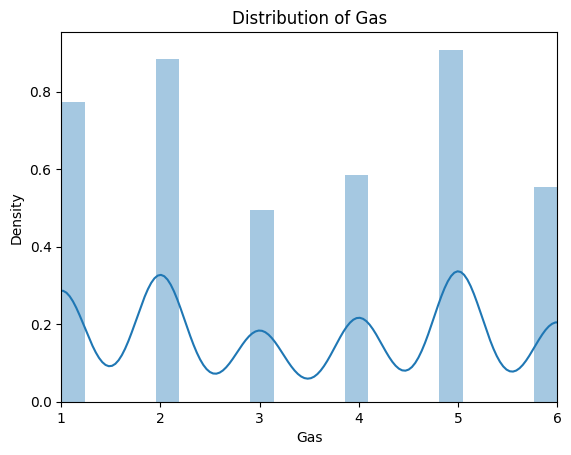

In [11]:
sns.distplot(df.Gas)
plt.xlim(1, 6)
plt.title('Distribution of Gas')
plt.show()

### 3. Concentration

In [12]:
conc = df.iloc[:,3]

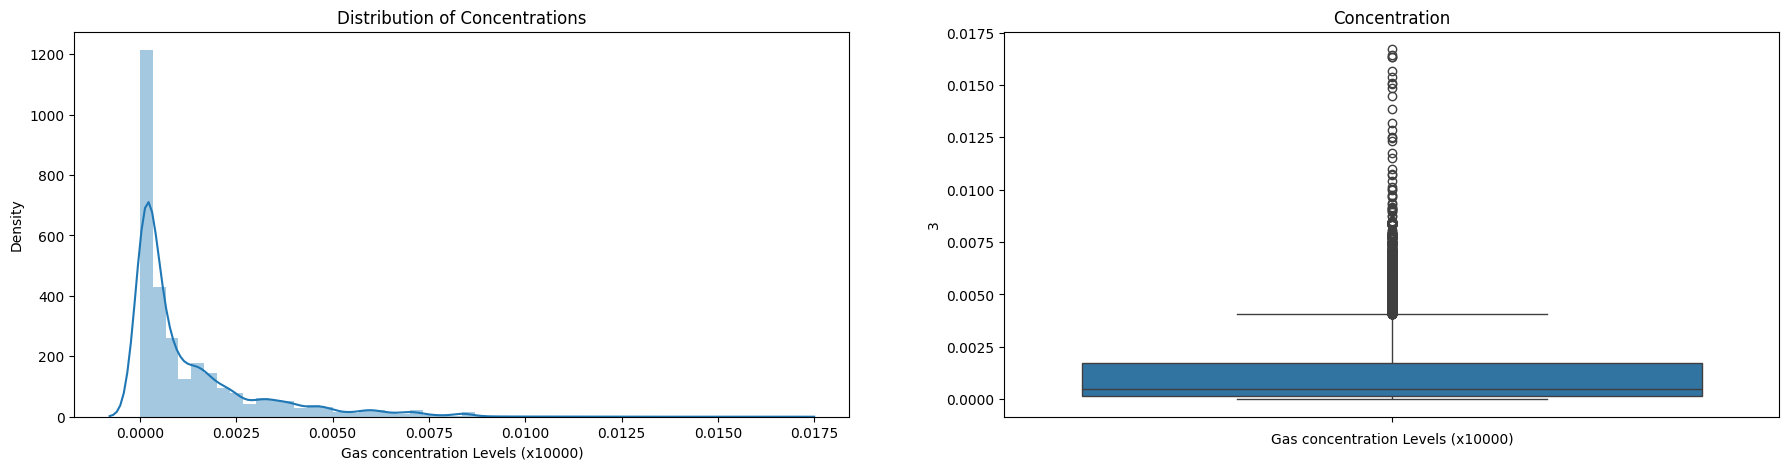

In [13]:
# Divide concentrations for readability in plot
conc_red = conc.apply(lambda x: x/10000)

fig = plt.figure(figsize=(22, 5))
fig.add_subplot(121)
sns.distplot(conc_red)
plt.title('Distribution of Concentrations')
plt.xlabel('Gas concentration Levels (x10000)')

fig.add_subplot(122)
sns.boxplot(conc_red)
plt.title('Concentration')
plt.xlabel('Gas concentration Levels (x10000)')

plt.show()

In [14]:
print("Skew of Gas concentration is: {}".format(conc.skew().round(decimals=2)))


Skew of Gas concentration is: 2.34


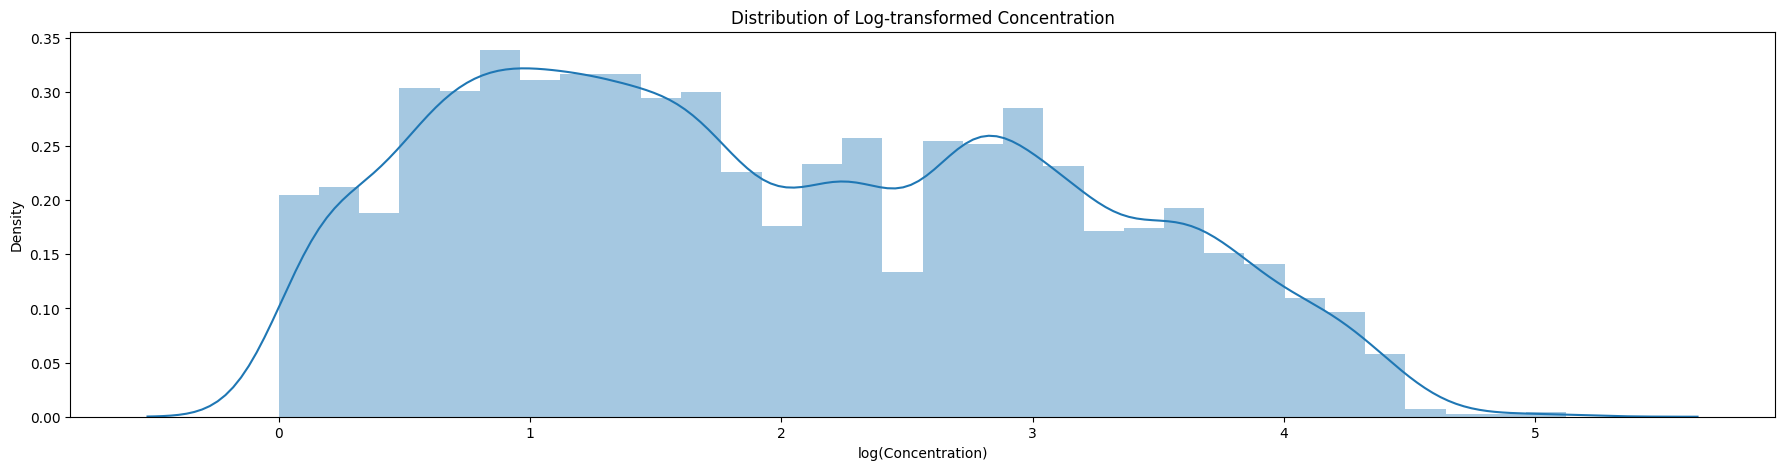

In [15]:
plt.figure(figsize=(22, 5))
sns.distplot(np.log(conc + 1 - min(conc)))
plt.title('Distribution of Log-transformed Concentration')
plt.xlabel('log(Concentration)')
plt.show()

In [16]:
attr = df.iloc[:,2:].copy()
attr.head()


,2,3,4,5,6,7,8,9,10,11,...,119,120,121,122,123,124,125,126,127,128
0,6.879777,8.015992,9.693781,10.395843,-6.536626,-8.133166,-9.791521,38322.2808,6.188925,8.030706,...,-2.527925,-3.265795,7569.4060,5.047939,2.276808,4.044630,4.462146,-1.542438,-2.157614,-2.467686
1,8.010889,11.923483,14.852244,15.832542,-9.475042,-12.010242,-14.690817,49066.2905,7.449631,11.603252,...,-3.431357,-3.867759,9439.2753,6.171099,3.041165,5.965897,6.484808,-2.020718,-2.976985,-3.414326
2,10.051341,15.340578,19.488398,20.497949,-12.591432,-15.902563,-18.574193,60936.1982,9.080379,14.618957,...,-4.286628,-4.829090,11239.6850,7.103307,3.624351,7.399946,8.102601,-2.474856,-3.703714,-4.142096
3,12.166384,18.824513,24.350939,25.197136,-14.415973,-18.179882,-21.087264,67652.2422,10.429562,17.879554,...,-5.176868,-5.792909,12906.3768,7.865789,4.189577,8.636098,9.585280,-2.866935,-4.348264,-5.098510
4,15.558152,24.911318,33.082695,34.439873,-19.629322,-31.771161,-28.489385,86513.1313,13.192445,23.091552,...,-6.725848,-7.586845,16157.8314,9.359470,5.296148,11.308695,12.523619,-3.912921,-6.101352,-6.257501


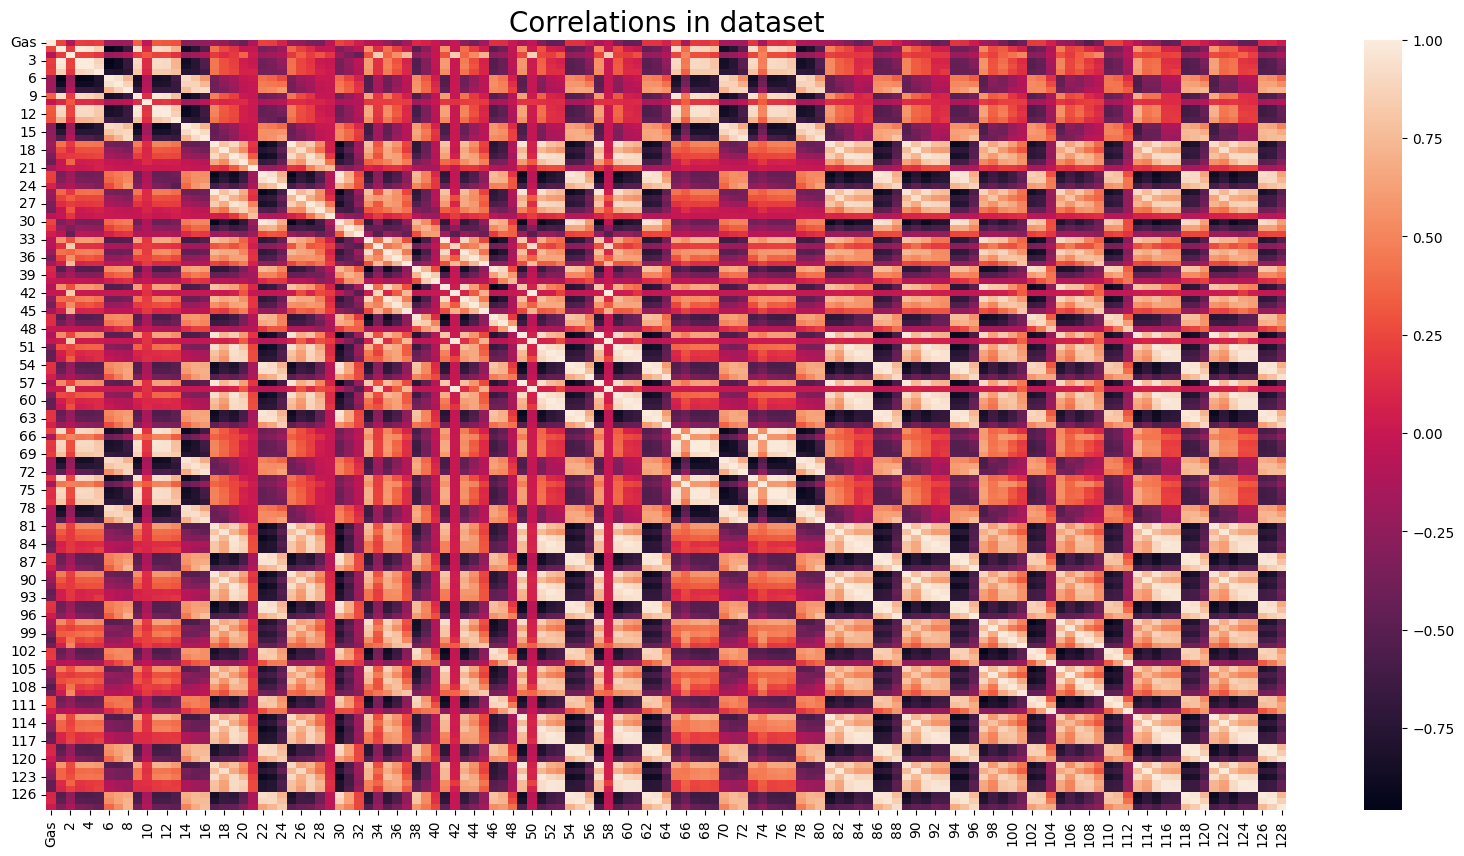

In [17]:
correlation = df.corr()

f, ax = plt.subplots(figsize=(20,10))
plt.title('Correlations in dataset', size=20)
sns.heatmap(correlation)
plt.show()

In [18]:
# Sort correletions of the concentration column
conc_corr = correlation.iloc[:,1].sort_values(ascending=False)

# Show all but with itself (correlation with self = 1)
conc_corr[1:].head(20)

3      0.983710
4      0.964275
73     0.931922
9      0.925908
65     0.918925
11     0.907179
75     0.907141
67     0.894082
76     0.883304
12     0.880074
68     0.870845
5      0.852414
77     0.808763
69     0.779136
13     0.694674
121    0.584990
113    0.583377
33     0.571334
41     0.565753
49     0.536699
Name: 1, dtype: float64

In [19]:
# The bottom of the list 
conc_corr[1:].tail(20)

102   -0.462186
119   -0.467363
127   -0.473974
54    -0.474011
72    -0.497401
38    -0.500108
46    -0.501147
118   -0.514472
126   -0.520602
80    -0.538281
16    -0.544650
8     -0.677211
71    -0.752262
15    -0.755876
79    -0.801174
70    -0.862056
78    -0.874178
14    -0.878040
7     -0.882787
6     -0.951382
Name: 1, dtype: float64

In [20]:
conc_corr.index

Index([ 1,  3,  4, 73,  9, 65, 11, 75, 67, 76,
       ...
       16,  8, 71, 15, 79, 70, 78, 14,  7,  6],
      dtype='object', length=129)

---

## Feature Selection

![image]


### A. Filter Selection (Spearman Rank Correlation)

In [31]:
import pandas as pd
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split

# Asumsikan df adalah DataFrame Anda dan 'Gas' adalah kolom target.
# Membagi dataset menjadi features dan target
X = df.drop('Gas', axis=1)
y = df['Gas']

# Menghitung korelasi Spearman antara setiap fitur dengan target
correlation_scores = []
for column in X.columns:
    # Menghitung korelasi Spearman dan nilai p
    correlation, pvalue = spearmanr(X[column], y)
    correlation_scores.append((column, correlation, pvalue))

# Mengubah daftar korelasi menjadi DataFrame
correlation_scores_df = pd.DataFrame(correlation_scores, columns=['Feature', 'Correlation', 'Pvalue'])

# Menyaring fitur dengan nilai korelasi yang signifikan (misalnya, p-value < 0.05)
significant_features = correlation_scores_df[correlation_scores_df['Pvalue'] < 0.05]

# Mengurutkan fitur berdasarkan nilai korelasi absolut yang tinggi
significant_features = significant_features.reindex(significant_features.Correlation.abs().sort_values(ascending=False).index)

# Memilih fitur dengan korelasi terkuat, misalnya 10 fitur teratas
top_features = significant_features.head(10)['Feature']

# Menggunakan hanya fitur terpilih untuk X
X_selected = X[top_features]

# Memisahkan data menjadi set pelatihan dan pengujian
X_train_filter, X_test_filter, y_train_filter, y_test_filter = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# X_train dan y_train sekarang berisi hanya fitur terpilih untuk pelatihan model
# X_test dan y_test digunakan untuk validasi model

In [35]:
X_train_filter.head()

,28,20,109,29,60,124,52,101,116,92
2287,11.301638,11.562599,11.183877,16.525522,19.156364,17.664434,18.449119,11.218504,19.149604,9.951694
8170,3.043936,3.117679,5.263982,5.994385,5.839779,4.508874,5.710335,5.052408,4.791854,2.479902
13020,3.024634,3.008921,4.441622,6.342204,6.847827,5.650456,6.094041,5.408385,6.141581,3.230462
965,16.405780,16.649644,14.801629,22.103288,30.048966,28.125141,27.837616,15.468583,31.632609,13.600683
2955,90.618326,0.357145,331.284524,499.699096,28.576130,28.580294,24.729914,327.548001,37.697656,14.766935


In [128]:
significant_features.reindex(significant_features.Correlation.abs().sort_values(ascending=False).index)[:10]

,Feature,Correlation,Pvalue
27,28,-0.532117,0.0
19,20,-0.518911,0.0
108,109,-0.501761,0.0
28,29,-0.495987,0.0
59,60,-0.494159,0.0
123,124,-0.493973,0.0
51,52,-0.493927,0.0
100,101,-0.492679,0.0
115,116,-0.491935,0.0
91,92,-0.489674,0.0


In [23]:
print(
    X_train_filter.shape, y_train_filter.shape
), 
print(
    X_test_filter.shape, 
    y_test_filter.shape
)

(11128, 10) (11128,)
(2782, 10) (2782,)


### B. Wrapper (Recursive Feature Estimation)

In [24]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Asumsikan `df` adalah DataFrame yang telah Anda muat dari dataset gas Anda
# dan 'Gas' adalah kolom target.
X = df.drop('Gas', axis=1)
y = df['Gas']

# Menginisialisasi Logistic Regression sebagai estimator
# LogisticRegression adalah pilihan yang baik untuk baseline karena cukup ringan
estimator = LogisticRegression(solver='liblinear')

# Mengatur RFE
# Pilih jumlah fitur yang ingin Anda seleksi. Misalnya, saya akan pilih 10 fitur.
selector = RFE(estimator, n_features_to_select=10)

# Melatih RFE dengan data Anda
selector = selector.fit(X, y)

# Mendapatkan mask fitur yang dipilih
selected_features = X.columns[selector.support_]

# Membuat DataFrame baru hanya


In [33]:
X_selected = X[selected_features]
X_train_wrapper, X_test_wrapper, y_train_wrapper, y_test_wrapper = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [36]:
X_train_wrapper.head()

,18,26,74,82,86,90,94,99,102,107
2287,3.755683,3.636483,4.635298,3.969498,-3.150087,3.710584,-2.718905,2.325872,-1.177359,2.253953
8170,2.067371,2.012608,1.919673,2.059075,-0.524299,2.006561,-0.442450,0.886914,-0.250890,0.911012
13020,3.010264,2.953943,3.333298,2.894414,-1.232166,3.194410,-1.362986,1.087408,-0.550724,1.062562
965,4.811397,4.663974,6.439720,4.925646,-3.917859,4.963530,-3.285723,3.056855,-1.247084,2.960409
2955,0.968714,0.209933,1.181288,2.363209,-10.357040,2.351546,-8.311774,5.741376,-2.022314,5.435404


### C. Embedded

In [51]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Asumsikan 'df' adalah DataFrame yang berisi data gas Anda, dan 'Gas' adalah target.
X = df.drop('Gas', axis=1)
y = df['Gas']

# Membagi data menjadi set pelatihan dan pengujian
X_train_embedded, X_test_embedded, y_train_embedded, y_test_embedded = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat model RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model dengan set pelatihan
model.fit(X_train_embedded, y_train_embedded)

# Menggunakan SelectFromModel untuk memilih fitur berdasarkan pentingnya
sfm = SelectFromModel(model, prefit=True)

# Transformasi set pelatihan dan pengujian untuk hanya memuat fitur yang dipilih
X_train_embedded = sfm.transform(X_train_embedded)
X_test_embedded = sfm.transform(X_test_embedded)

# Jumlah fitur yang dipilih
print(f"Original number of features: {X.shape[1]}")
print(f"Selected number of features: {X_train_embedded.shape[1]}")


Original number of features: 128
Selected number of features: 46


### D. KNN Classification

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Menginisialisasi KNN classifier dengan jumlah tetangga, misalnya k=5
knn_filter = KNeighborsClassifier(n_neighbors=5)
knn_wrapper = KNeighborsClassifier(n_neighbors=5)
knn_embedded = KNeighborsClassifier(n_neighbors=5)

# Melatih model KNN dengan set pelatihan
knn_filter.fit(X_train_filter, y_train_filter)
knn_wrapper.fit(X_train_wrapper, y_train_wrapper)
knn_embedded.fit(X_train_embedded, y_train_embedded)


KNeighborsClassifier()

In [132]:
results = []

for x in ["filter", "wrapper", "embedded"]:
    y_pred = vars()[f"knn_{x}"].predict(vars()[f"X_test_{x}"])
    results.append({
        "type": x, 
        # "report": list(confusion_matrix(vars()[f"y_test_{x}"], y_pred)),
        "accuracy": accuracy_score(vars()[f"y_test_{x}"], y_pred)
    })
    

In [134]:
results

[{'type': 'filter', 'accuracy': 0.9295470884255931},
 {'type': 'wrapper', 'accuracy': 0.9662113587347232},
 {'type': 'embedded', 'accuracy': 0.9759166067577283}]

---

## SMOTE Oversampling

In [75]:
from sklearn.datasets import load_wine
from imblearn.over_sampling import SMOTE
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Hitung distribusi kelas sebelum oversampling
print("Distribusi kelas sebelum SMOTE:", np.bincount(y_train))

# Inisialisasi SMOTE dan sampel dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Hitung distribusi kelas setelah oversampling
print("Distribusi kelas setelah SMOTE:", np.bincount(y_resampled))

Distribusi kelas sebelum SMOTE: [   0 2045 2319 1323 1543 2420 1478]
Distribusi kelas setelah SMOTE: [   0 2420 2420 2420 2420 2420 2420]


In [78]:
knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_resampled, y_resampled)

KNeighborsClassifier()

In [80]:
y_pred = knn_smote.predict(X_test)
accuracy_score(y_test, y_pred)

0.9805895039539899

---

## Combine SMOTE x Best Feature Selection

In [82]:
# Hitung distribusi kelas sebelum oversampling
print("Distribusi kelas sebelum SMOTE:", np.bincount(y_train))

# Inisialisasi SMOTE dan sampel dataset
smote = SMOTE(random_state=42)
X_embed_resampled, y_embed_resampled = smote.fit_resample(X_train_embedded, y_train_embedded)

# Hitung distribusi kelas setelah oversampling
print("Distribusi kelas setelah SMOTE:", np.bincount(y_resampled))

Distribusi kelas sebelum SMOTE: [   0 2045 2319 1323 1543 2420 1478]
Distribusi kelas setelah SMOTE: [   0 2420 2420 2420 2420 2420 2420]


In [84]:
knn_embedded_smote = KNeighborsClassifier(n_neighbors=5)
knn_embedded_smote.fit(X_embed_resampled, y_embed_resampled)

KNeighborsClassifier()

In [89]:
y_pred = knn_embedded_smote.predict(X_test_embedded)
accuracy_score(y_test_embedded, y_pred)

0.9777138749101366

In [90]:
y_pred

array([2, 4, 6, ..., 2, 4, 4])